# 1. Importing Necessary Packages and Libraries

In [1]:
import warnings
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 as cv
import PIL as pil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import image_dataset_from_directory, plot_model
import keras_tuner as kt

# Model Inheritance (VGG16)

In [5]:
from keras.applications.vgg16 import VGG16

# 2. Train and Test Data Augmentation

In [6]:
train_data = image_dataset_from_directory(directory='/kaggle/input/dogs-vs-cats/train',
                                          labels='inferred', 
                                          label_mode='int', 
                                          batch_size=32, 
                                          image_size=(224,224))

test_data = image_dataset_from_directory(directory='/kaggle/input/dogs-vs-cats/test',
                                          labels='inferred', 
                                          label_mode='int', 
                                          batch_size=32, 
                                          image_size=(224,224))


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
type(train_data)

tensorflow.python.data.ops.batch_op._BatchDataset

# 3. EDA/Data Preprocessing

In [8]:
def process(image, label):
    image = tf.cast(image/255.0, tf.float32)
    return image, label

In [9]:
train_data = train_data.map(process)
test_data = test_data.map(process)

In [10]:
type(train_data)

tensorflow.python.data.ops.map_op._MapDataset

In [11]:
calls = EarlyStopping(patience=5, verbose=True)

# 4. Modelling Using Transfer Learning

In [12]:
MyModel = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
MyModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
MyModel.trainable = False

In [15]:
MyModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
model = Sequential()

model.add(MyModel)
model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

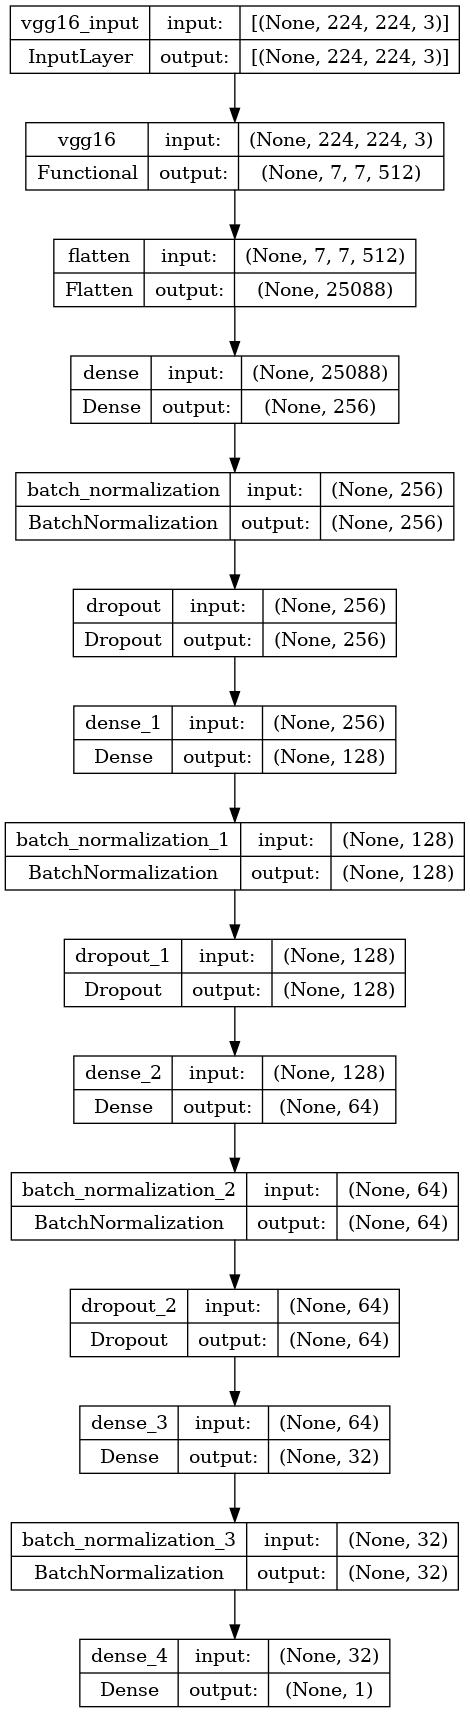

In [18]:
plot_model(model, show_shapes=True)

In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
outcome = model.fit(train_data, epochs=100, validation_data=test_data, verbose=True, callbacks=calls)

Epoch 1/100
625/625 [==============================] - 143s 201ms/step - loss: 0.2667 - accuracy: 0.8854 - val_loss: 0.1758 - val_accuracy: 0.9268
Epoch 2/100
625/625 [==============================] - 108s 172ms/step - loss: 0.1853 - accuracy: 0.9255 - val_loss: 0.2548 - val_accuracy: 0.8880
Epoch 3/100
625/625 [==============================] - 128s 204ms/step - loss: 0.1541 - accuracy: 0.9388 - val_loss: 0.1915 - val_accuracy: 0.9192
Epoch 4/100
625/625 [==============================] - 108s 172ms/step - loss: 0.1384 - accuracy: 0.9445 - val_loss: 0.1915 - val_accuracy: 0.9194
Epoch 5/100
625/625 [==============================] - 108s 172ms/step - loss: 0.1240 - accuracy: 0.9510 - val_loss: 0.2052 - val_accuracy: 0.9228
Epoch 6/100
625/625 [==============================] - 128s 204ms/step - loss: 0.1087 - accuracy: 0.9583 - val_loss: 0.2045 - val_accuracy: 0.9168
Epoch 6: early stopping


In [21]:
dog = cv.imread('/kaggle/input/dogs-vs-cats/test/dogs/dog.100.jpg')
cat = cv.imread('/kaggle/input/dogs-vs-cats/test/cats/cat.10.jpg')

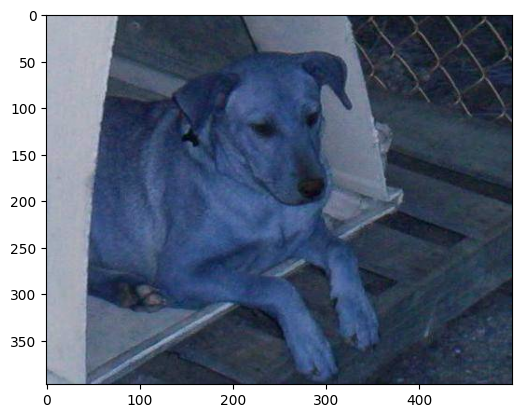

In [22]:
plt.imshow(dog)

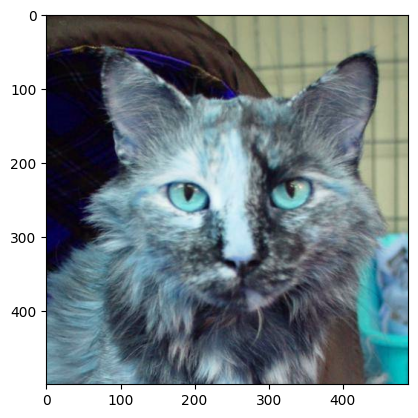

In [23]:
plt.imshow(cat)

In [24]:
dog = cv.resize(dog, (224,224))
cat = cv.resize(cat, (224,224))

In [25]:
dog_input = dog.reshape((1, 224,224,3))
cat_input = cat.reshape((1,224,224,3))

In [26]:
model.predict(dog_input)

1/1 [==============================] - 1s 923ms/step


array([[1.]], dtype=float32)

In [27]:
model.predict(cat_input)

1/1 [==============================] - 0s 27ms/step


array([[0.]], dtype=float32)

In [28]:
outcome.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# 5. Model Evaluation

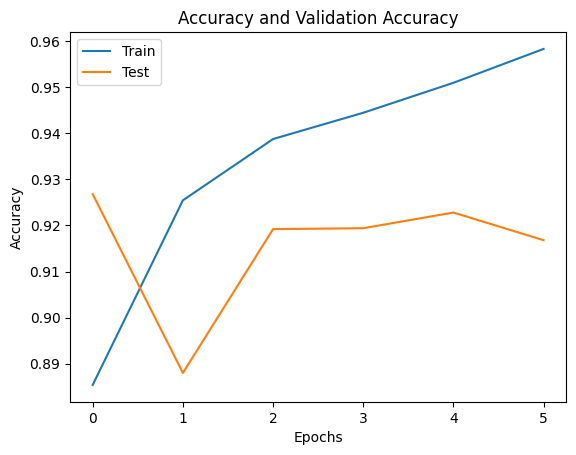

In [29]:
plt.plot(outcome.history['accuracy'])
plt.plot(outcome.history['val_accuracy'])
plt.title('Accuracy and Validation Accuracy')
plt.legend(['Train', 'Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

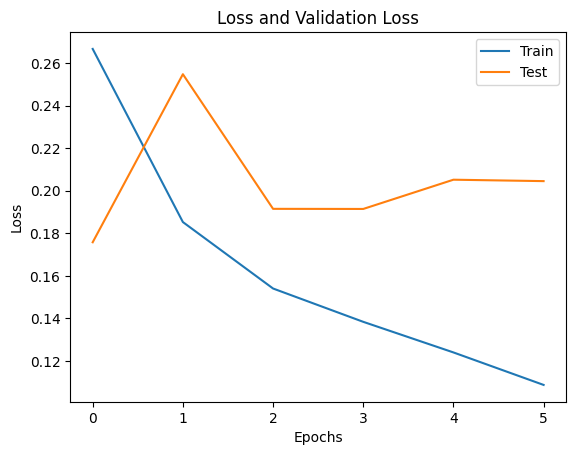

In [30]:
plt.plot(outcome.history['loss'])
plt.plot(outcome.history['val_loss'])
plt.title('Loss and Validation Loss')
plt.legend(['Train', 'Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Thanks